# Kwaterniony model AR (Levinson-Durbin)
--- 

## Wczytanie danych
---

Stabilny zapis lotu `38_bs78_out_GPS_alt2pos.ulg`.

In [13]:
import pyulog
from library.data_reader import read_attitude_quaternions, read_nav_quaternions

log = pyulog.ULog('./ulogs/37_bs78_out_GPS_alt2pos.ulg')
att_q, att_t = read_attitude_quaternions(log)
nav_q, nav_t = read_nav_quaternions(log)

## Interpolacja
---

Zaimplementowano metodę bazującą na *interpolacja funkcjami sklejanymi*, jako `spline_interpolation()`, dostarczającą bliskie wyniki. Zaimplementowano również metodę bazującą na metodzie *slerp*, jako funkcję `squad_interpolation`.  

Dla zachowania ciągłości napisano funkcję zwracającą indeksy podsekwencji rozdzielonych maksymalną odległością `discontinued_subspaces`

In [14]:
import numpy as np
from library.quaternion_interp import discontinued_subspaces, spline_interpolation

# Get pseudo continuous signal (max space 10ms)
max_space = 10e4

args_partial_signal = discontinued_subspaces(att_t, max_length = max_space)
args_part = args_partial_signal[0] # Get first part

att_t = att_t[args_part[0]:args_part[1]]
att_q = att_q[args_part[0]:args_part[1]]

# Config interpolation
dt = 2000
degree = 3

est_t = np.arange(att_t[0], att_t[-1], dt)
est_q = spline_interpolation(att_q, att_t, est_t, spline_degree=degree)

### Wynik interpolacji (składowe kwaternionu)

Do wyświetlenie rezultatów można wykorzystać `display_quaternion_compare` dla składowych kwaternionu.

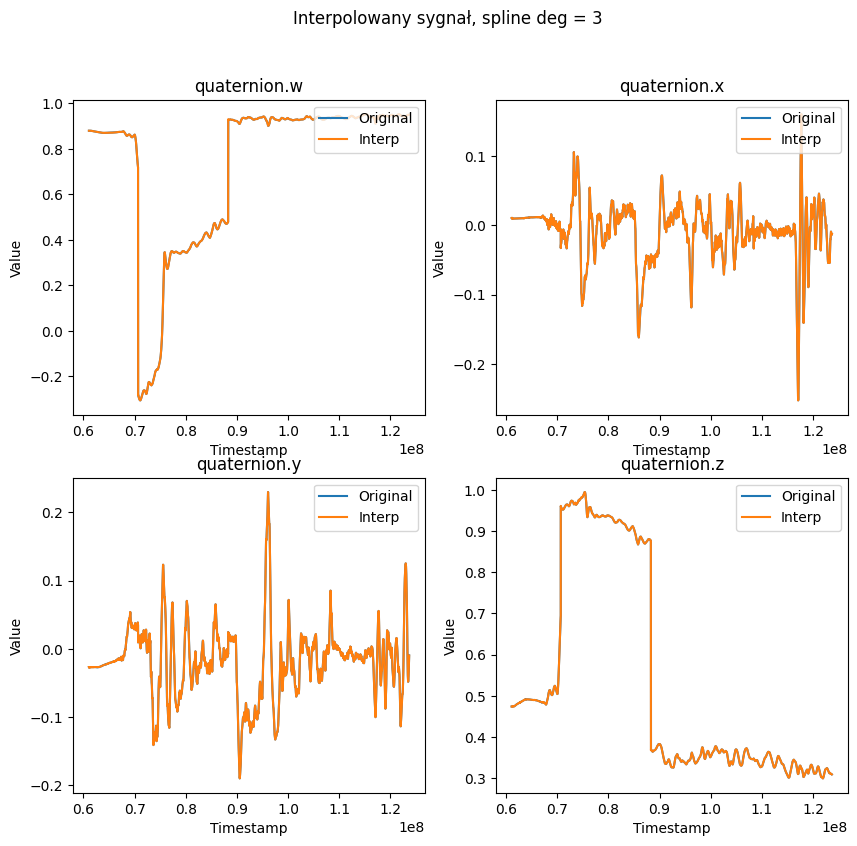

In [15]:
from library.quaternion_vision import display_quaternion_compare

display_quaternion_compare([att_q, est_q], [att_t, est_t], ['Original', 'Interp'],
    "Interpolowany sygnał, spline deg = {}".format(degree))

### Wynik interpolacji (kąty Eulera)

W przypadku kątów Eulera `display_quaternion_as_euler`. 

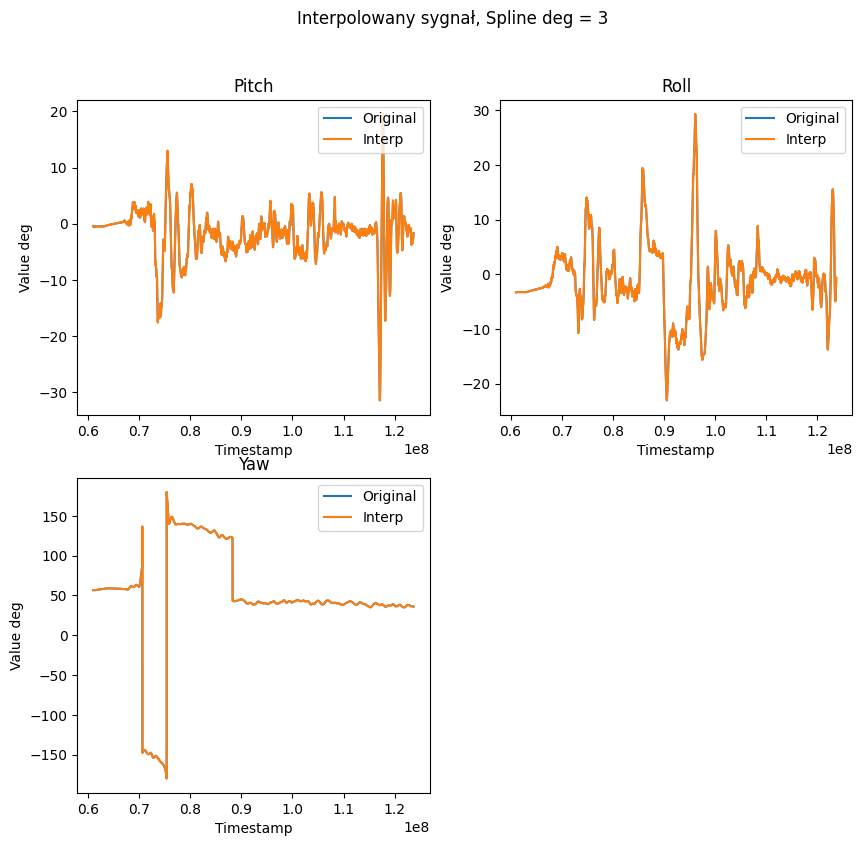

In [16]:
from library.quaternion_vision import display_quaternion_as_euler

display_quaternion_as_euler([att_q, est_q], [att_t, est_t], ['Original', 'Interp'],
    "Interpolowany sygnał, Spline deg = {}".format(degree))

## Implementacja modelu AR
---

### Macierz autokorelacji

In [17]:
def compute_correlation_matrix(windowing_signal: np.ndarray, M_order: int) -> np.ndarray :
    """
    Determines the quaternion correlation matrix.
    Args:
        windowing_signal (np.ndarray[np.quaternion]): Windowing signal
        M_order (int): Filter order

    Returns:
        np.ndarray[np.quaternion]: Corelation matrix 
    """
    n = windowing_signal.size
    r_size = M_order + 1

    r_matrix = np.zeros((r_size, r_size), dtype = np.quaternion)
    for i in range(0, (n - M_order - 1) ):
        v = windowing_signal[i : (i + M_order + 1)]
        r_matrix += np.outer(v, v.conjugate())
    
    return r_matrix

### Levinson-Durbin 

In [18]:
def compute_coefficient_LD_a(r_matrix: np.ndarray, M_order: int) -> np.ndarray:
    
    a_arr = np.zeros((0), dtype = np.quaternion)
    
    # Step 1: P=0 -> a0 = 1
    # Step 2: P=1
    a_arr = np.append(a_arr, r_matrix[1,0] / r_matrix[1,1])

    # Step 3: Iterative for P in (1 : M_order)
    for i in range(1, M_order):
        nominator   = r_matrix[i+1, 0] - np.sum(a_arr * r_matrix[i, :i])
        denominator = r_matrix[i+1, i+1] - np.sum(a_arr[::-1] * r_matrix[i, :i])
        temp_a = nominator / denominator
        a_arr = np.append(a_arr, temp_a)

        # Coeff actualization 
        for j in range(i):
            a_arr[j] = a_arr[j] - temp_a * a_arr[i-j-1]
    
    return a_arr

In [19]:
def compute_coefficient_LD(r_matrix: np.ndarray, M_order: int) -> np.ndarray:
    
    a_arr = np.zeros((0), dtype = np.quaternion)
    
    # Step 1: P=0 -> a0 = 1
    # Step 2: P=1
    a_arr = np.append(a_arr, r_matrix[1,0] / r_matrix[1,1])

    # Step 3: Iterative for P in (1 : M_order)
    for i in range(1, M_order):
        nominator   = r_matrix[i+1, 0] - np.sum(a_arr * r_matrix[i, :i])
        denominator = r_matrix[i+1, i+1] - np.sum(a_arr[::-1] * r_matrix[i, :i])
        temp_a = nominator / denominator
        a_arr = np.append(a_arr, temp_a)

        # Coeff actualization 
        for j in range(i):
            a_arr[j] = a_arr[j] - temp_a * a_arr[i-j-1]
    
    return a_arr

## Test predykcji
---

In [27]:
# Configuration section
N_window = 20
M_order = 2

pred_window = {
    'min': 3000 + N_window,
    'max': est_t.shape[0],
}
ex_q   = est_q[pred_window['min']:pred_window['max']]
pred_q = np.zeros((pred_window['max'] - pred_window['min']), dtype = np.quaternion)
ex_t = pred_t = est_t[pred_window['min']:pred_window['max']]

for i in range(pred_window['min'], pred_window['max']):
    r_matrix = compute_correlation_matrix(est_q[i-N_window : i][::-1], M_order)
    a_arr = compute_coefficient_LD(r_matrix, M_order)
    pred_q[i - pred_window['min']] = np.sum(a_arr * est_q[i-M_order : i][::-1]).normalized()


### Uzyskane rezultaty

#### MSE dla kątów Eulera

In [28]:
from library.quaternion_utils import quaternion_euler_mse, quaternion_euler_difference

EULER_COMPONENTS = ['Pitch', 'Roll', 'Yaw']
mse_e = quaternion_euler_mse(ex_q, pred_q)
for mse, c in zip(mse_e, EULER_COMPONENTS):
    print(f'{c+" mse:": <10} {mse}')

diff_e = quaternion_euler_difference(ex_q, pred_q)
max_e = np.max(diff_e, axis=0)
for max_e, c in zip(max_e, EULER_COMPONENTS):
    print(f'{c+" Max err :": <15} {max_e}')


Pitch mse: 0.007762186950140536
Roll mse:  0.005744048777214273
Yaw mse:   0.6159026447922457
Pitch Max err : 0.570111390112487
Roll Max err :  0.9651090380945675
Yaw Max err :   96.0490971548142


#### Wykres predykcji

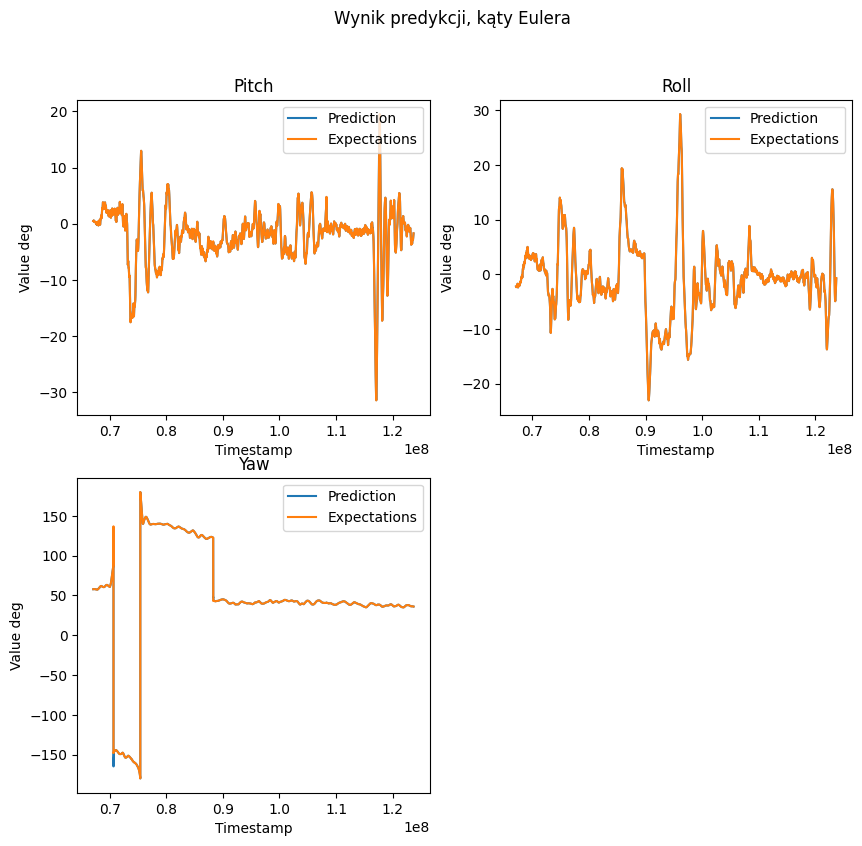

In [29]:
from library.quaternion_vision import display_quaternion_as_euler

display_quaternion_as_euler(
    [pred_q, ex_q], 
    [pred_t, ex_t],  
    ['Prediction', 'Expectations'],
    "Wynik predykcji, kąty Eulera")

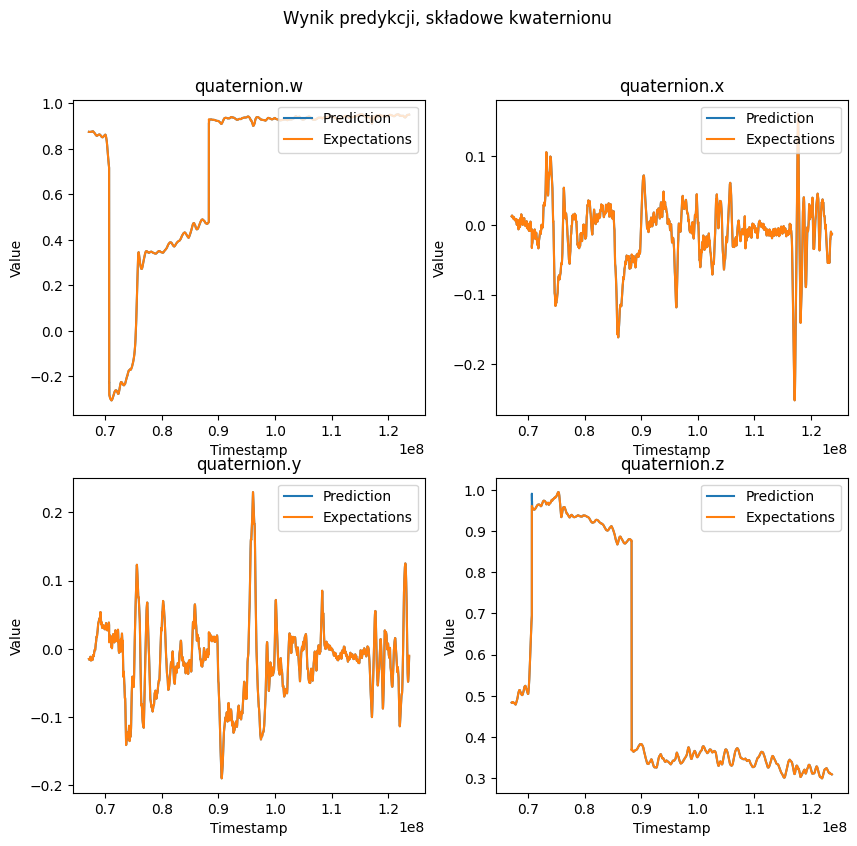

In [23]:
from library.quaternion_vision import display_quaternion_compare

display_quaternion_compare(
    [pred_q, ex_q], 
    [pred_t, ex_t], 
    ['Prediction', 'Expectations'],
    "Wynik predykcji, składowe kwaternionu")

In [40]:
class IterativeCorrelation():
    def __init__(self, n_window: int, m_order: int) -> None:
        self.n_window   = n_window
        self.m_order    = m_order
        self.r_size     = m_order + 1
        self.is_filled  = False
        self.r_count    = self.n_window - self.m_order
        self.moving_idx = self.n_window - self.m_order - 1
        
        self.r_comp = np.zeros((self.r_size, self.r_size, 
                                self.n_window - self.m_order), dtype = np.quaternion)


    def _fill(self, windowing_signal: np.ndarray) -> None:
        for i in range(0, (self.n_window - self.m_order - 1)):
            v = windowing_signal[i : (i + self.m_order + 1)]
            self.r_comp[:,:,i] = np.outer(v, v.conjugate())

        self.is_filled = True


    def push(self, windowing_signal: np.ndarray) -> None:
        if not self.is_filled:
            self._fill(windowing_signal)
            return

        v = windowing_signal[0 : (0 + self.m_order + 1)]
        self.r_comp[:,:,self.moving_idx] = np.outer(v, v.conjugate())

        self.moving_idx = (self.moving_idx - 1) % self.r_count

    
    def get(self) -> np.ndarray:
        return np.sum(self.r_comp, axis = 0)

In [38]:
N_window = 20
M_order = 2

pred_window = {
    'min': 3000 + N_window,
    'max': est_t.shape[0],
}
ex_q   = est_q[pred_window['min']:pred_window['max']]
pred_q = np.zeros((pred_window['max'] - pred_window['min']), dtype = np.quaternion)
ex_t = pred_t = est_t[pred_window['min']:pred_window['max']]

ic = IterativeCorrelation(N_window, M_order)

for i in range(pred_window['min'], pred_window['max']):
    r_matrix = compute_correlation_matrix(est_q[i-N_window : i][::-1], M_order)
    ic.push(est_q[i-N_window : i][::-1])
    r_it = ic.get()

    print(r_matrix)
    print(r_it)

[[[0 1]
  [2 3]]

 [[4 5]
  [6 7]]]


array([[ 4,  6],
       [ 8, 10]])